<a href="https://colab.research.google.com/github/m-a-hasan/ai-colab/blob/main/04_transfer_learning_with_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if we are using GPU for faster runtime
!nvidia-smi

Thu Sep  1 06:11:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get 10% of data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-09-01 06:11:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   104MB/s    in 1.5s    

2022-09-01 06:11:43 (104 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check file numbers and folders
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in '10_food_classes_10_percent'.
there are 10 directories and 0 images in '10_food_classes_10_percent/train'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
there are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
there are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Setup image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          class_mode="categorical",
                                                          batch_size=BATCH_SIZE)

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        class_mode="categorical",
                                                        batch_size = BATCH_SIZE)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


We have more testing than training, because we would like to train in a smaller dataset but want to test as much as we can

**Callbacks - things to run while to model is training**
* Tracking with tensorboard
* Checkpointing
* Stop when ceases to improve

In [ ]:
import tensorflow as tf

In [ ]:
# Create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard logfiles to {log_dir}")
  return tensorboard_callback

**Classification** - take model as is (same input-output)

**Feature vecotor** - take a model; freeze its weight and change its input and output to fit our purpose

**Fine tuning** - most layers are frozen, top 2/3 layers are trained with different input and output

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

#EfficientNetB0 feature vector (version 1)
efficientnet_v1_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# EfficientNetB0 feature vector (version 2)
efficientnet_v2_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub URL, creates a Sequential model using it and returns that model
  """

  # Download a pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze all the underlying layer
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create model
  model = tf.keras.Sequential([
      feature_extractor_layer, # Use this as the base
      layers.Dense(num_classes, activation="softmax", name="output_layer") # Create our own output layer
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(model_url= resnet_url,
                            num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

In [ ]:
# Fit
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  # Add tensorboard callback
                                  callbacks=[create_tensorboard_callback(
                                      dir_name="tensorflow_hub", # save experiment logs here
                                      experiment_name="resnet50V2" # name of the log files
                                  )])

Saving tensorboard logfiles to tensorflow_hub/resnet50V2/20220901-061158
Epoch 1/5
24/24 [==============================] - 32s 759ms/step - loss: 1.8487 - accuracy: 0.3947 - val_loss: 1.2078 - val_accuracy: 0.6032
Epoch 2/5
24/24 [==============================] - 17s 747ms/step - loss: 0.8836 - accuracy: 0.7467 - val_loss: 0.8812 - val_accuracy: 0.7120
Epoch 3/5
24/24 [==============================] - 20s 865ms/step - loss: 0.6112 - accuracy: 0.8227 - val_loss: 0.7424 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.4610 - accuracy: 0.8800 - val_loss: 0.7143 - val_accuracy: 0.7644
Epoch 5/5
24/24 [==============================] - 17s 744ms/step - loss: 0.3742 - accuracy: 0.9253 - val_loss: 0.6728 - val_accuracy: 0.7812


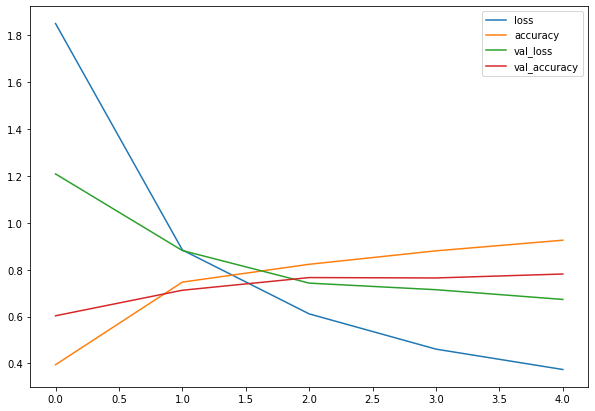

In [ ]:
# Plot
from pandas import DataFrame as df
import matplotlib.pyplot as plt
df(resnet_history.history).plot(figsize=(10,7))
plt.show()

In [ ]:
# Summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Create model
efficientnet_v1_model = create_model(model_url=efficientnet_v1_url,
                                     num_classes=train_data_10_percent.num_classes)

# Compile model
efficientnet_v1_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss="categorical_crossentropy",
                              metrics=["accuracy"])

# Fit
efficientnet_v1_history = efficientnet_v1_model.fit(train_data_10_percent,
                                                    epochs=5,
                                                    steps_per_epoch=len(train_data_10_percent),
                                                    validation_data=test_data_10_percent,
                                                    validation_steps=len(test_data_10_percent),
                                                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                           experiment_name="efficientnetB0")])

Saving tensorboard logfiles to tensorflow_hub/efficientnetB0/20220901-062035
Epoch 1/5
24/24 [==============================] - 28s 816ms/step - loss: 1.8819 - accuracy: 0.4067 - val_loss: 1.3520 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 15s 650ms/step - loss: 1.0657 - accuracy: 0.7653 - val_loss: 0.8805 - val_accuracy: 0.8104
Epoch 3/5
24/24 [==============================] - 18s 755ms/step - loss: 0.7547 - accuracy: 0.8440 - val_loss: 0.7040 - val_accuracy: 0.8364
Epoch 4/5
24/24 [==============================] - 16s 704ms/step - loss: 0.6044 - accuracy: 0.8720 - val_loss: 0.6132 - val_accuracy: 0.8488
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.5104 - accuracy: 0.8880 - val_loss: 0.5584 - val_accuracy: 0.8596


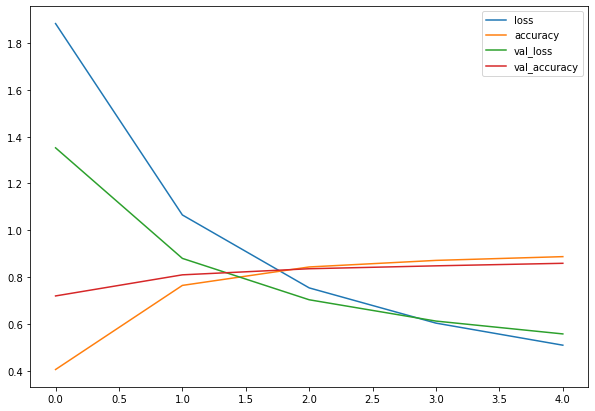

In [ ]:
df(efficientnet_v1_history.history).plot(figsize=(10, 7))

In [ ]:
efficientnet_v1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Create model with efficientnet v2
efficientnet_v2_model = create_model(model_url=efficientnet_v2_url,
                                     num_classes=train_data_10_percent.num_classes)

# Compile model
efficientnet_v2_model.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss="categorical_crossentropy",
                              metrics=["accuracy"])

# Fit model
efficientnet_v2_history = efficientnet_v2_model.fit(train_data_10_percent,
                                                    epochs=5,
                                                    steps_per_epoch=len(train_data_10_percent),
                                                    validation_data=test_data_10_percent,
                                                    validation_steps=len(test_data_10_percent),
                                                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                           experiment_name="efficientnetB2")])

Saving tensorboard logfiles to tensorflow_hub/efficientnetB2/20220901-062747
Epoch 1/5
24/24 [==============================] - 23s 695ms/step - loss: 1.8578 - accuracy: 0.4267 - val_loss: 1.4266 - val_accuracy: 0.6508
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.2493 - accuracy: 0.6840 - val_loss: 1.0863 - val_accuracy: 0.7072
Epoch 3/5
24/24 [==============================] - 17s 735ms/step - loss: 0.9806 - accuracy: 0.7560 - val_loss: 0.9317 - val_accuracy: 0.7332
Epoch 4/5
24/24 [==============================] - 18s 776ms/step - loss: 0.8246 - accuracy: 0.7987 - val_loss: 0.8432 - val_accuracy: 0.7568
Epoch 5/5
24/24 [==============================] - 16s 700ms/step - loss: 0.7214 - accuracy: 0.8320 - val_loss: 0.7880 - val_accuracy: 0.7644


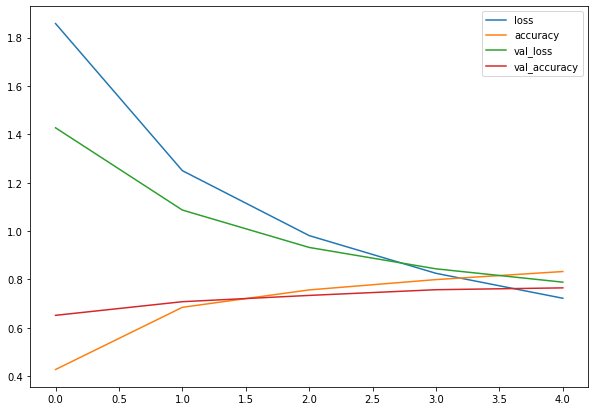

In [ ]:
df(efficientnet_v2_history.history).plot(figsize=(10, 7))

In [ ]:
efficientnet_v2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


In [ ]:
# Upload data to tensorboard
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNet V1 VS V2 VS ResNet50V2" \
  --description "Comparing 3 different TensorFlow Hub feature extraction models using 10% training images" \
  --one_shot # one_shot makes sure the command exits as soon as the logs are uploaded


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=Puley8ouf2RxSQaAA1aQkqC8F9vXUN&prompt=consent&access_type=off

In [ ]:
# Check experiments saved on the tensorboard
!tensorboard dev list

https://tensorboard.dev/experiment/wlDi5ytRRwatw8cv8B245A/
	Name                 EfficientNet V1 VS V2 VS ResNet50V2
	Description          Comparing 3 different TensorFlow Hub feature extraction models using 10% training images
	Id                   wlDi5ytRRwatw8cv8B245A
	Created              2022-09-01 06:41:15 (4 minutes ago)
	Updated              2022-09-01 06:41:19 (4 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  8573290
Total: 1 experiment(s)


In [ ]:
# Delete experiment (because TensorBoard.dev is public)
!tensorboard dev delete --experiment_id wlDi5ytRRwatw8cv8B245A

Deleted experiment wlDi5ytRRwatw8cv8B245A.


In [ ]:
# Check if experiment exists
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
